# CA2 Part 1 (Time Series Forecasting)

Done By: Darius Khoo  
  

Admin Number: 2222259  
  

Class: DAAA/FT/2A/06  
  

---

### **Background**
Using the Energy Consumption Dataset to train time series models and forecast
the gas consumption, electricity consumption and water consumption in the
future.

### **Task** 
- Write the code to solve the time series prediction. For the time series model,use Statsmodels only (do not use other 3rd party libraries such as autoML).

- Tune the hyperparameters of the time series model to maximize the accuracy for training data and testing data prediction.

- Write a short report detailing your implementation, your experiments and analysis in the Jupyter notebook (along with your python code and comments).

- Create a set of slides with the highlights of your Jupyter notebook. Explain the time series prediction process, model building and evaluation. Write your conclusions.

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Statistical Analysis
# Statistical Tests, Plots, and Visualizations
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram


# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

from warnings import filterwarnings 
filterwarnings('ignore')
rng = np.random.RandomState(42)

df = pd.read_csv('./data/Energy Consumption Dataset.csv')

o P-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  


o P-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [225]:
df.head(8)

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4
5,1/6/1990,23.4,580.9,503.2
6,1/7/1990,24.6,626.2,448.3
7,1/8/1990,24.8,632.5,411.7


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [227]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gas Consumption (tons),397.0,23.785139,4.903452,11.6,20.2,23.5,27.9,46.0
Electricity Consumption (MWh),397.0,888.472544,153.877594,553.2,771.1,897.8,1005.2,1294.0
Water Consumption (tons),397.0,484.953652,133.908863,44.4,384.4,487.4,580.2,811.0


we can immediately see outlier in the water consumption data

In [228]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")

display(df.dtypes)

df.set_index("DATE", inplace=True)

DATE                             datetime64[ns]
Gas Consumption (tons)                  float64
Electricity Consumption (MWh)           float64
Water Consumption (tons)                float64
dtype: object

> I set the Date column as a datetime dtype and made it my index 

In [229]:
print(f'the dates are from {df.index.min()} to {df.index.max()}')
print(f'{df.index[0]}, {df.index[1]}')

the dates are from 1990-01-01 00:00:00 to 2023-01-01 00:00:00
1990-01-01 00:00:00, 1990-02-01 00:00:00


> The range of dates and we can see what each date represents

---

## Univariate Analysis

In [230]:
# sns.displot(x='Gas Consumption (tons)', kde=True, height=8, data=df)
# plt.title('Distribution of Gas Consumption (tons)')
# plt.show()

In [231]:
# sns.displot(x='Electricity Consumption (MWh)', kde=True, height=8, data=df, color = 'black')
# plt.title('Distribution of Gas Consumption (tons)')
# plt.show()

In [232]:
# sns.displot(x='Gas Consumption (tons)', kde=True, height=8, data=df, color = 'orange')
# plt.title('Water Consumption (tons)')
# plt.show()

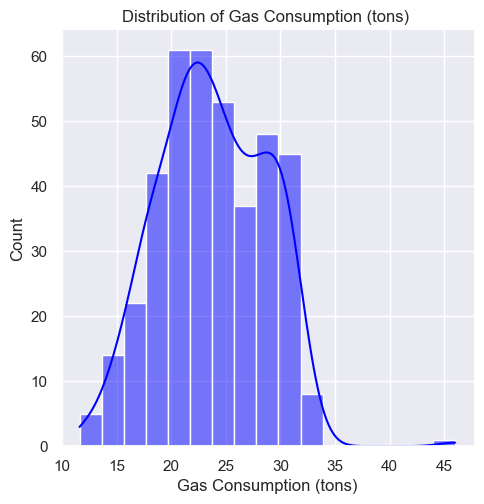

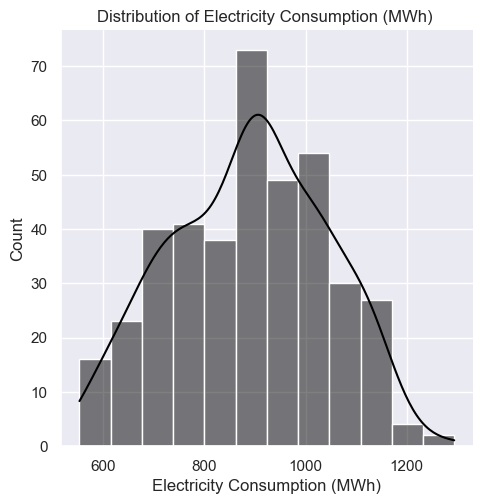

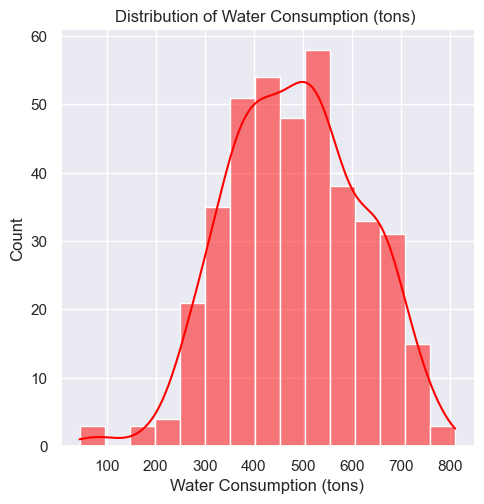

In [233]:
x_values = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
colors = ['blue', 'black', 'red']

for x, color in zip(x_values, colors):
    sns.displot(x=x, kde=True, height=5, data=df, color=color)
    plt.title(f"Distribution of {x} ")
    plt.show()

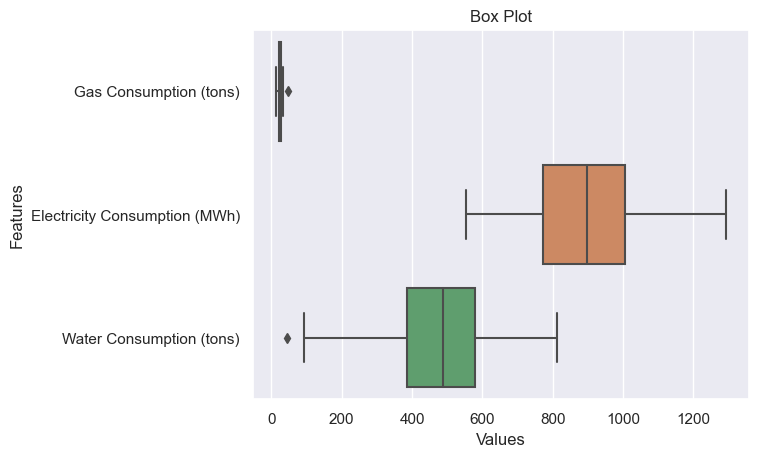

In [234]:
sns.boxplot(data=df , orient= 'h')

# Set labels and title
plt.xlabel("Values")
plt.ylabel("Features")
plt.title("Box Plot")

# Show the plot
plt.show()

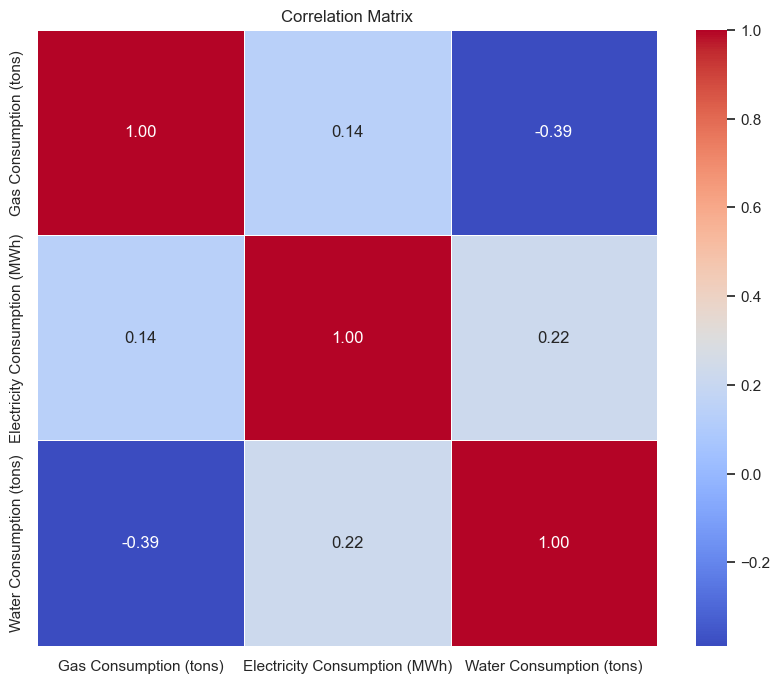

In [235]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

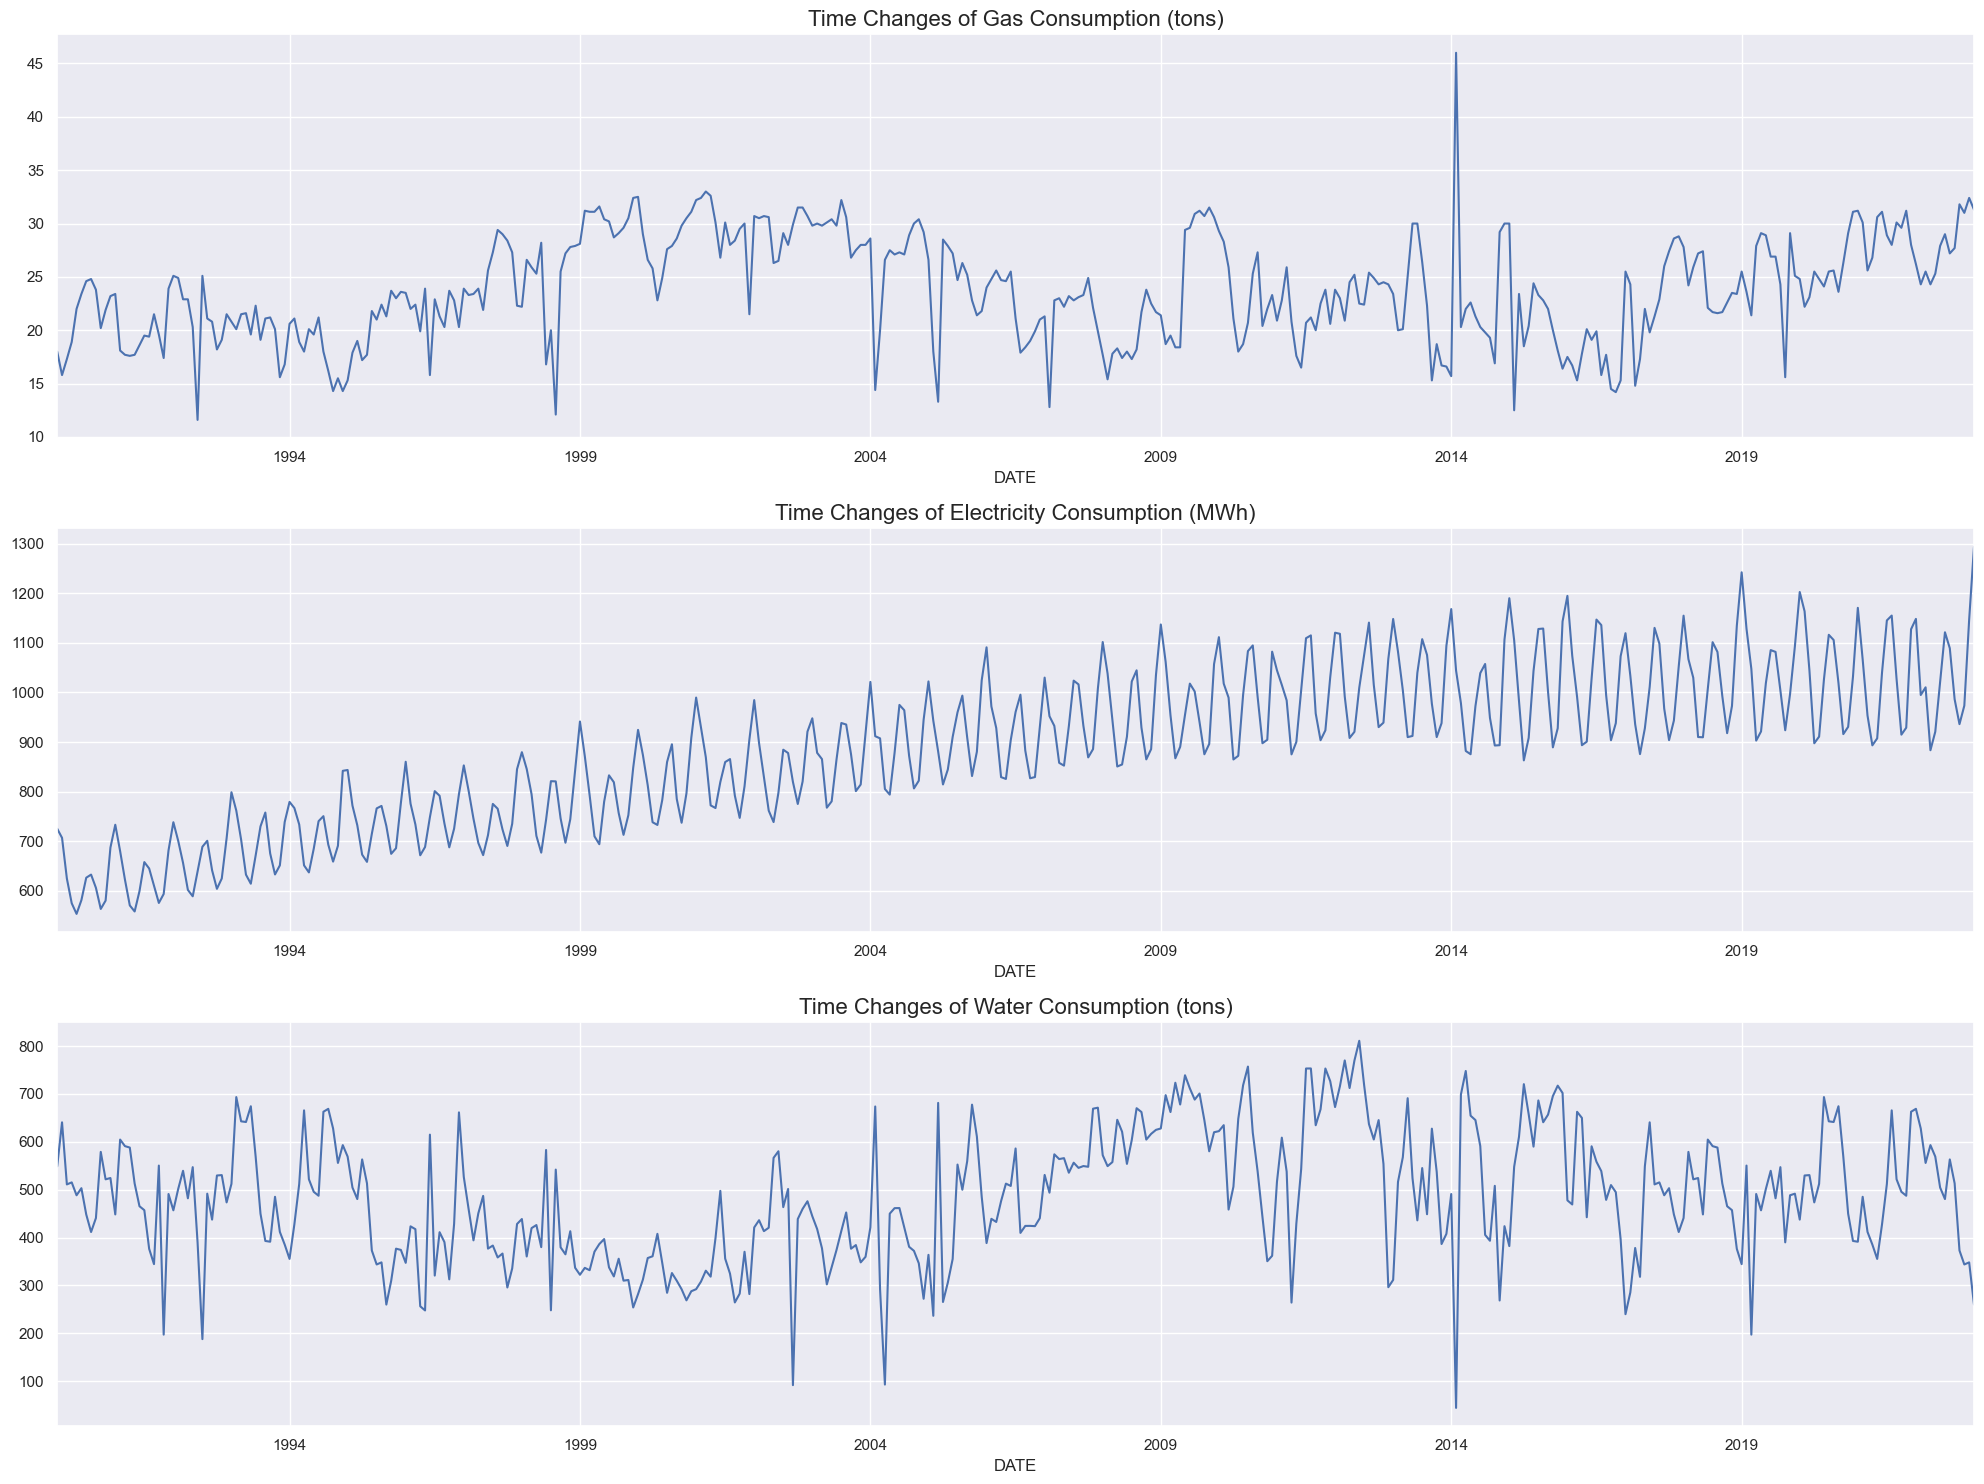

In [236]:
continuous = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
fig = plt.figure(tight_layout=True, figsize=(20, 15))
for i, column in enumerate(continuous):
    ax = fig.add_subplot(len(continuous), 1, i + 1)
    df[column].plot(ax=ax)
    ax.set_title("Time Changes of " + column, fontsize=16)
plt.show()

## Time Series Decomposition

Before we do anything we need to perform a few test to check the dataset, that includes
<!-- 
- Autocorrelation Test
- Stationarity Test
- Seasonality Test
- Unit Root Test
- Granger Causality Test
- Residual Analysis -->
- Test for Trends
- Test for Stationarity 
- Residual Analysis
- Outlier Analysis 

First lets start with the most basic test which is test for stationarity, many models such as ARIMA requires the data to be stationary to carry out forecasting, hence we need to check the each feature for stationarity, if it happens to not stationary we need to change that later on

Lets use the Dicky Fuller Test to evaluate

In [237]:
# adftest = adfuller(df['Gas Consumption (tons)'])
# signifcance_level = 0.05
# print('Number of observations:', adftest[3])
# print()
# print(signifcance_level)
# print('p-value', adftest[1])



# print()
# for key, value in adftest[4].items():
#     # print("Significance Level:", key)
#     print(f"Critical Value at {key}:", value)
    
# print()    

# print('Test Statistic Value:', adftest[0])


# print()
# if adftest[1] < signifcance_level:
#     print('Reject Null Hypothesis')
#     print('The data is Stationary')
# else:
#     print('Accept Null Hypothesis')
#     print('The data is Non-Stationary')

In [238]:
def evaluate_stationarity(data, columns, significance_level=0.05):
    for column in columns:
        adftest = adfuller(data[column])
        
        print("Column:", column)
        print("Number of observations:", adftest[3])
        print()
        print("Significance Level:", significance_level)
        print("p-value:", adftest[1])


        print()

        for key, value in adftest[4].items():
            print(f"Critical Value at {key}:", value)
        print()
        print('Test Statistic Value:', adftest[0])
        print()
        if adftest[1] < significance_level:
            print('Since p-value < significance level we reject the Null Hypothesis')
            print('The data is Stationary')
        elif adftest[1] > significance_level:
            print('Since p-value > significance level we Accept the Null Hypothesis')
            print('The data is Non-Stationary')

        print('-' * 50)
        print()


columns =  ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']  # Specify the columns to evaluate

evaluate_stationarity(df, columns)


Column: Gas Consumption (tons)
Number of observations: 390

Significance Level: 0.05
p-value: 0.01081065170706051

Critical Value at 1%: -3.4472291365835566
Critical Value at 5%: -2.8689795375849223
Critical Value at 10%: -2.5707330834976987

Test Statistic Value: -3.4043743333182728

Since p-value < significance level we reject the Null Hypothesis
The data is Stationary
--------------------------------------------------

Column: Electricity Consumption (MWh)
Number of observations: 381

Significance Level: 0.05
p-value: 0.18621802300336632

Critical Value at 1%: -3.4476305904172904
Critical Value at 5%: -2.869155980820355
Critical Value at 10%: -2.570827146203181

Test Statistic Value: -2.256980549592542

Since p-value > significance level we Accept the Null Hypothesis
The data is Non-Stationary
--------------------------------------------------

Column: Water Consumption (tons)
Number of observations: 392

Significance Level: 0.05
p-value: 8.984549388336973e-05

Critical Value at 1%:

In [239]:
# Perform KPSS test
result = kpss(df['Gas Consumption (tons)'])

# Extract test statistics and p-value
test_statistic = result[0]
p_value = result[1]
critical_values = result[3]

# Print the results
print(f"KPSS Test Statistic: {test_statistic}")
print(f"p-value: {p_value}")
print("Critical values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Interpret the results
if p_value < 0.05:
    print("The series is not stationary (reject the null hypothesis)")
else:
    print("The series is stationary (fail to reject the null hypothesis)")

KPSS Test Statistic: 0.3402153835554435
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)


In [240]:
def kpss_test(data):
    # Iterate over the columns of the data
    for column in data.columns:
        # Perform KPSS test
        result = kpss(data[column])

        # Extract test statistics and p-value
        test_statistic = result[0]
        p_value = result[1]
        critical_values = result[3]

        # Print the results
        print(f"Column: {column}")
        print(f"KPSS Test Statistic: {test_statistic}")
        print(f"p-value: {p_value}")
        print("Critical values:")
        for key, value in critical_values.items():
            print(f"  {key}: {value}")

        # Interpret the results
        if p_value < 0.05:
            print("The series is not stationary (reject the null hypothesis)")
        else:
            print("The series is stationary (fail to reject the null hypothesis)")
        print()

In [241]:
kpss_test(df)


Column: Gas Consumption (tons)
KPSS Test Statistic: 0.3402153835554435
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)

Column: Electricity Consumption (MWh)
KPSS Test Statistic: 3.531601452001429
p-value: 0.01
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is not stationary (reject the null hypothesis)

Column: Water Consumption (tons)
KPSS Test Statistic: 0.8388411776971113
p-value: 0.01
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is not stationary (reject the null hypothesis)



In [256]:
df1 = pd.DataFrame()

df1['Differenced_water'] = df['Water Consumption (tons)'].diff().dropna()
df1['Differenced_electricity'] = df['Electricity Consumption (MWh)'].diff().dropna()
kpss_test(df1)

Column: Differenced_water
KPSS Test Statistic: 0.11112601659149662
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)

Column: Differenced_electricity
KPSS Test Statistic: 0.14519067668792815
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)



In [243]:
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')
# pd.reset_option('display.width')
df

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


## *Seasonality Decomposition*

In [391]:
decompose = seasonal_decompose(df['Gas Consumption (tons)'])


trend = decompose.trend
seasonality = decompose.seasonal
residual = decompose.resid

# fig, axs = plt.subplots(4, 1, figsize=(10, 12))
# axs[0].plot(df['Gas Consumption (tons)'])
# axs[0].set_title('Original Time Series')

# axs[1].plot(trend)
# axs[1].set_title('Trend Component')

# axs[2].plot(seasonality)
# axs[2].set_title('Seasonality Component')

# axs[3].plot(residual)
# axs[3].set_title('Residual Component')


# plt.tight_layout()

# print(seasonality.head(15))

# decompose.plot()

# plt.show()





DATE
1990-01-01    0.916364
1990-02-01   -0.345615
1990-03-01   -0.953818
1990-04-01   -0.195876
1990-05-01   -0.010329
1990-06-01   -0.484157
1990-07-01    0.448774
1990-08-01   -0.117360
1990-09-01    0.154645
1990-10-01   -0.175563
1990-11-01    0.606859
1990-12-01    0.156077
1991-01-01    0.916364
1991-02-01   -0.345615
1991-03-01   -0.953818
Name: seasonal, dtype: float64


In [397]:
def plot_decomposition(data, column):
    decompose = seasonal_decompose(data[column])

    trend = decompose.trend
    seasonality = decompose.seasonal
    residual = decompose.resid

    print(f'the amount of datapoints per seasons is {len(seasonality.unique())}')
    
    fig, axs = plt.subplots(4, 1, figsize=(15, 12))
    axs[0].plot(data[column])
    axs[0].set_title('Original Time Series')

    axs[1].plot(trend)
    axs[1].set_title('Trend Component')

    axs[2].plot(seasonality)
    axs[2].set_title('Seasonality Component')

    # axs[3].plot(residual)
    # axs[3].set_title('Residual Component'

    axs[3].scatter(range(len(residual)), residual)
    axs[3].axhline(0, color='black', linestyle='--')  
    axs[3].set_title('Residual Component')

    plt.tight_layout()
    plt.show()


the amount of datapoints per seasons is 12


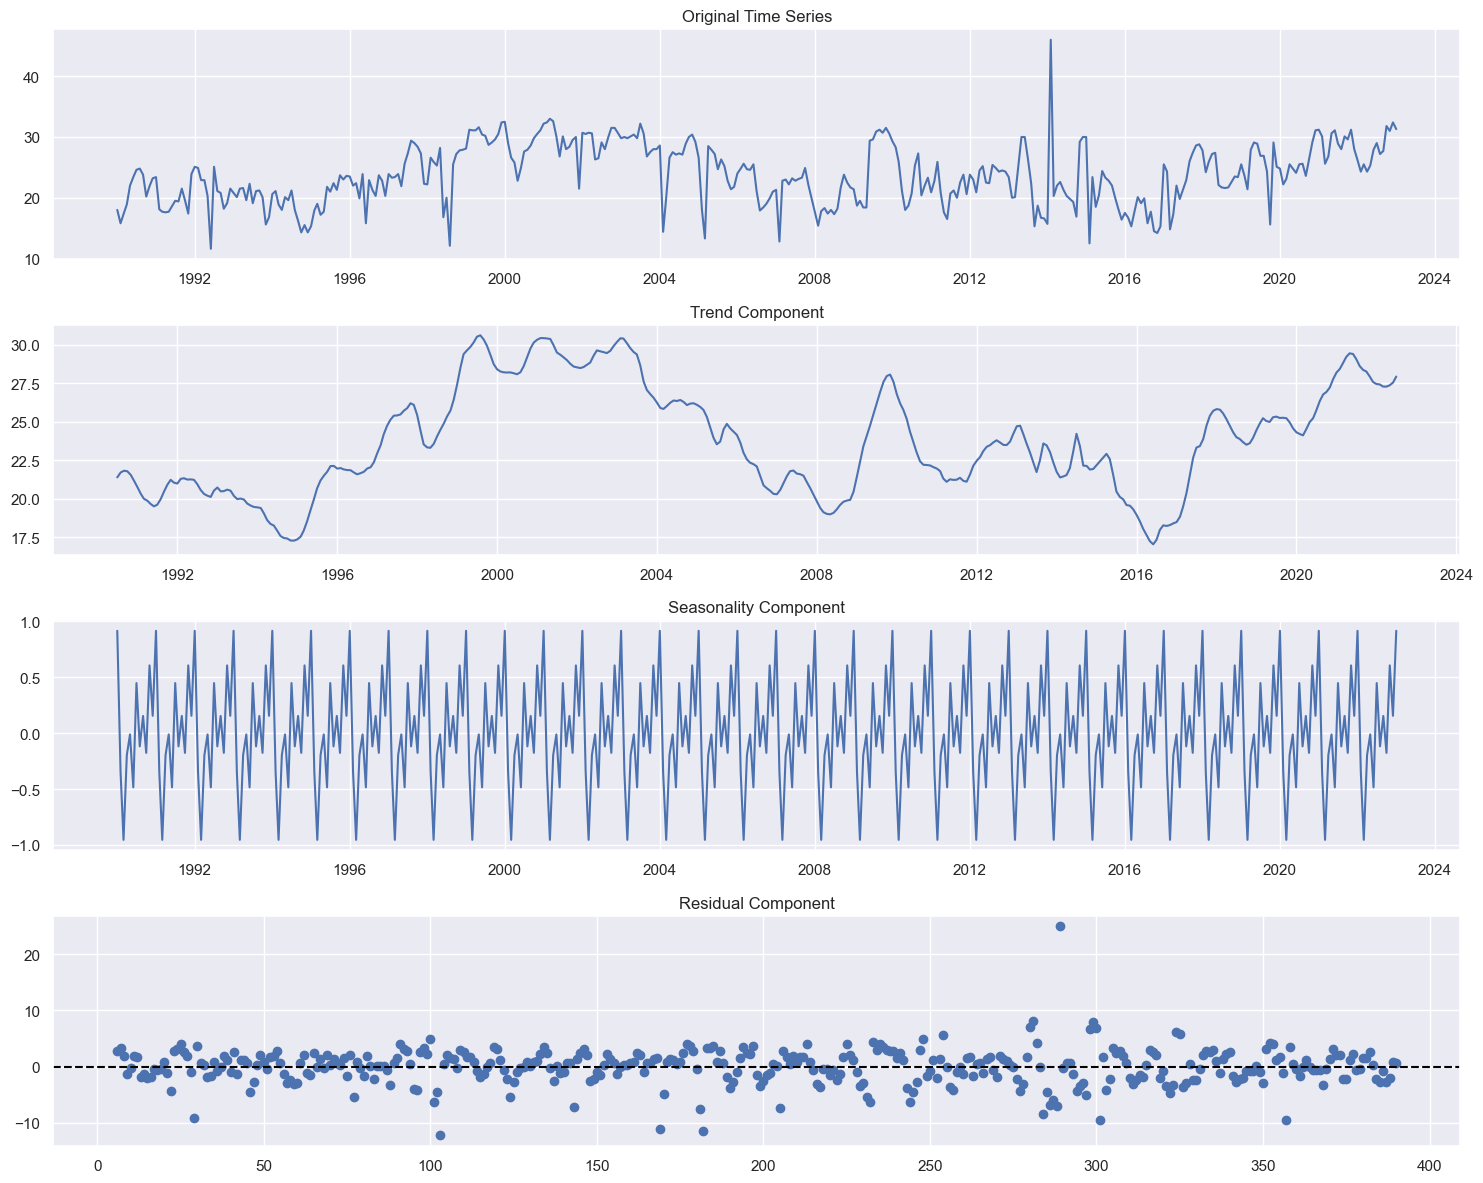

In [398]:
plot_decomposition(df, 'Gas Consumption (tons)')


the amount of datapoints per seasons is 12


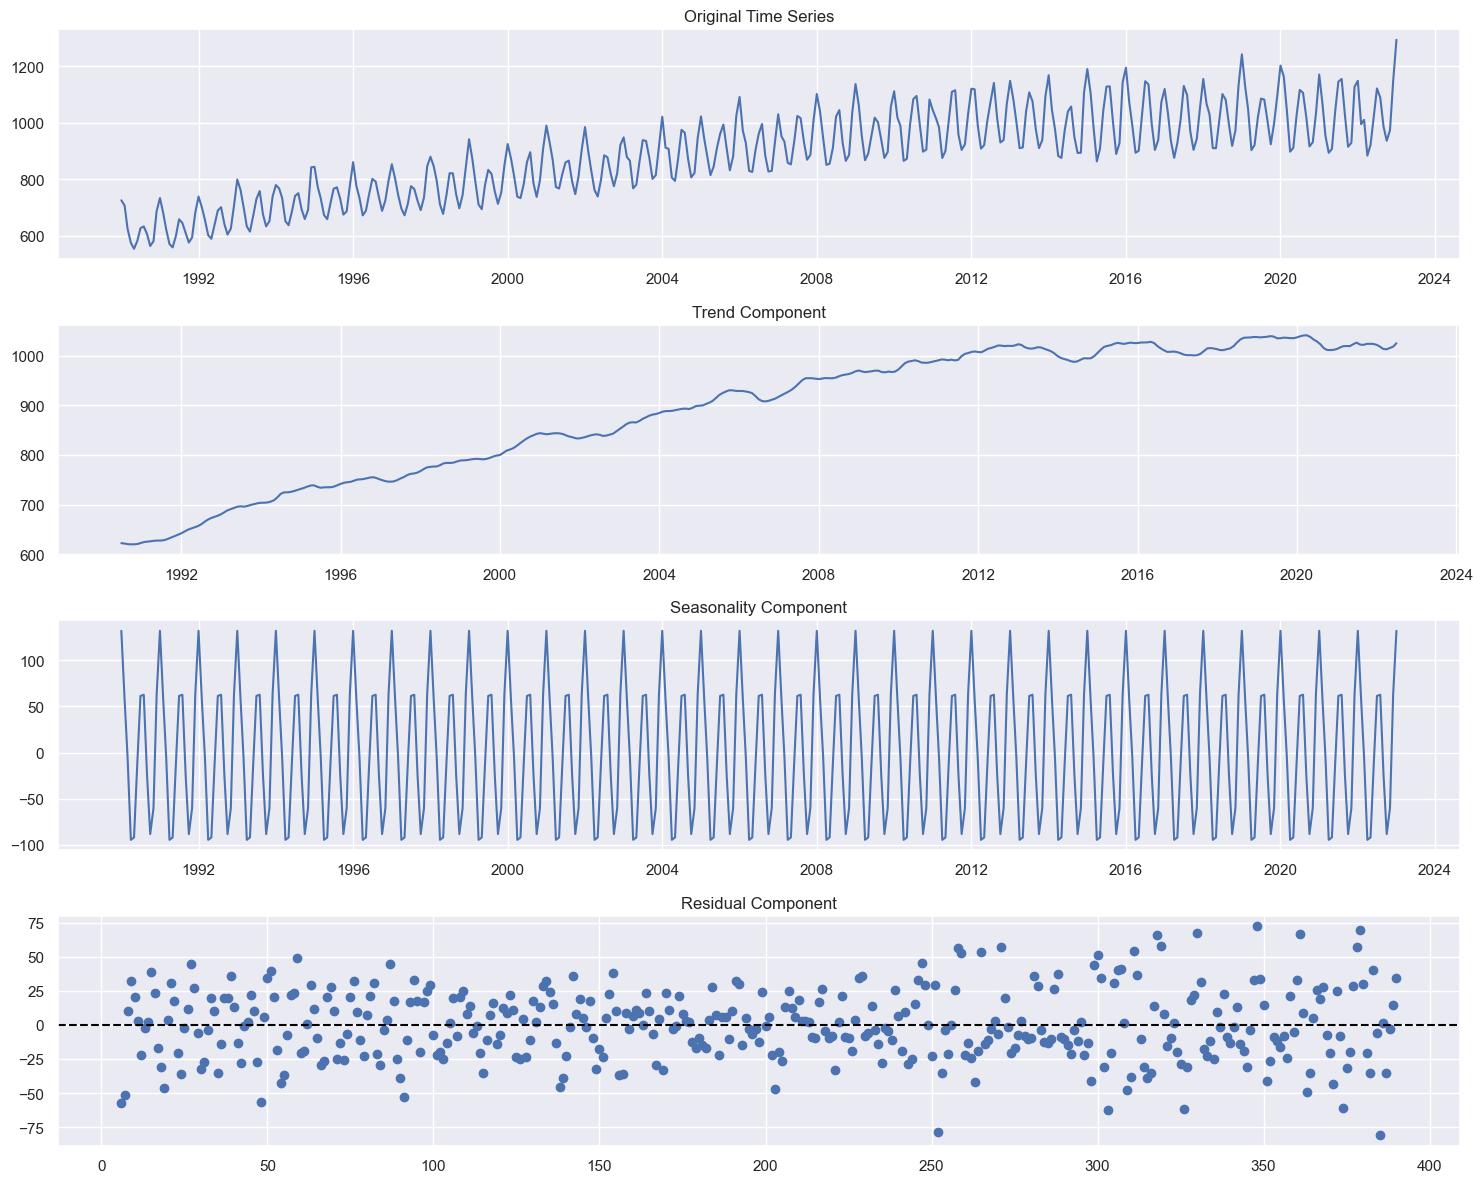

In [399]:
plot_decomposition(df, 'Electricity Consumption (MWh)')


the amount of datapoints per seasons is 12


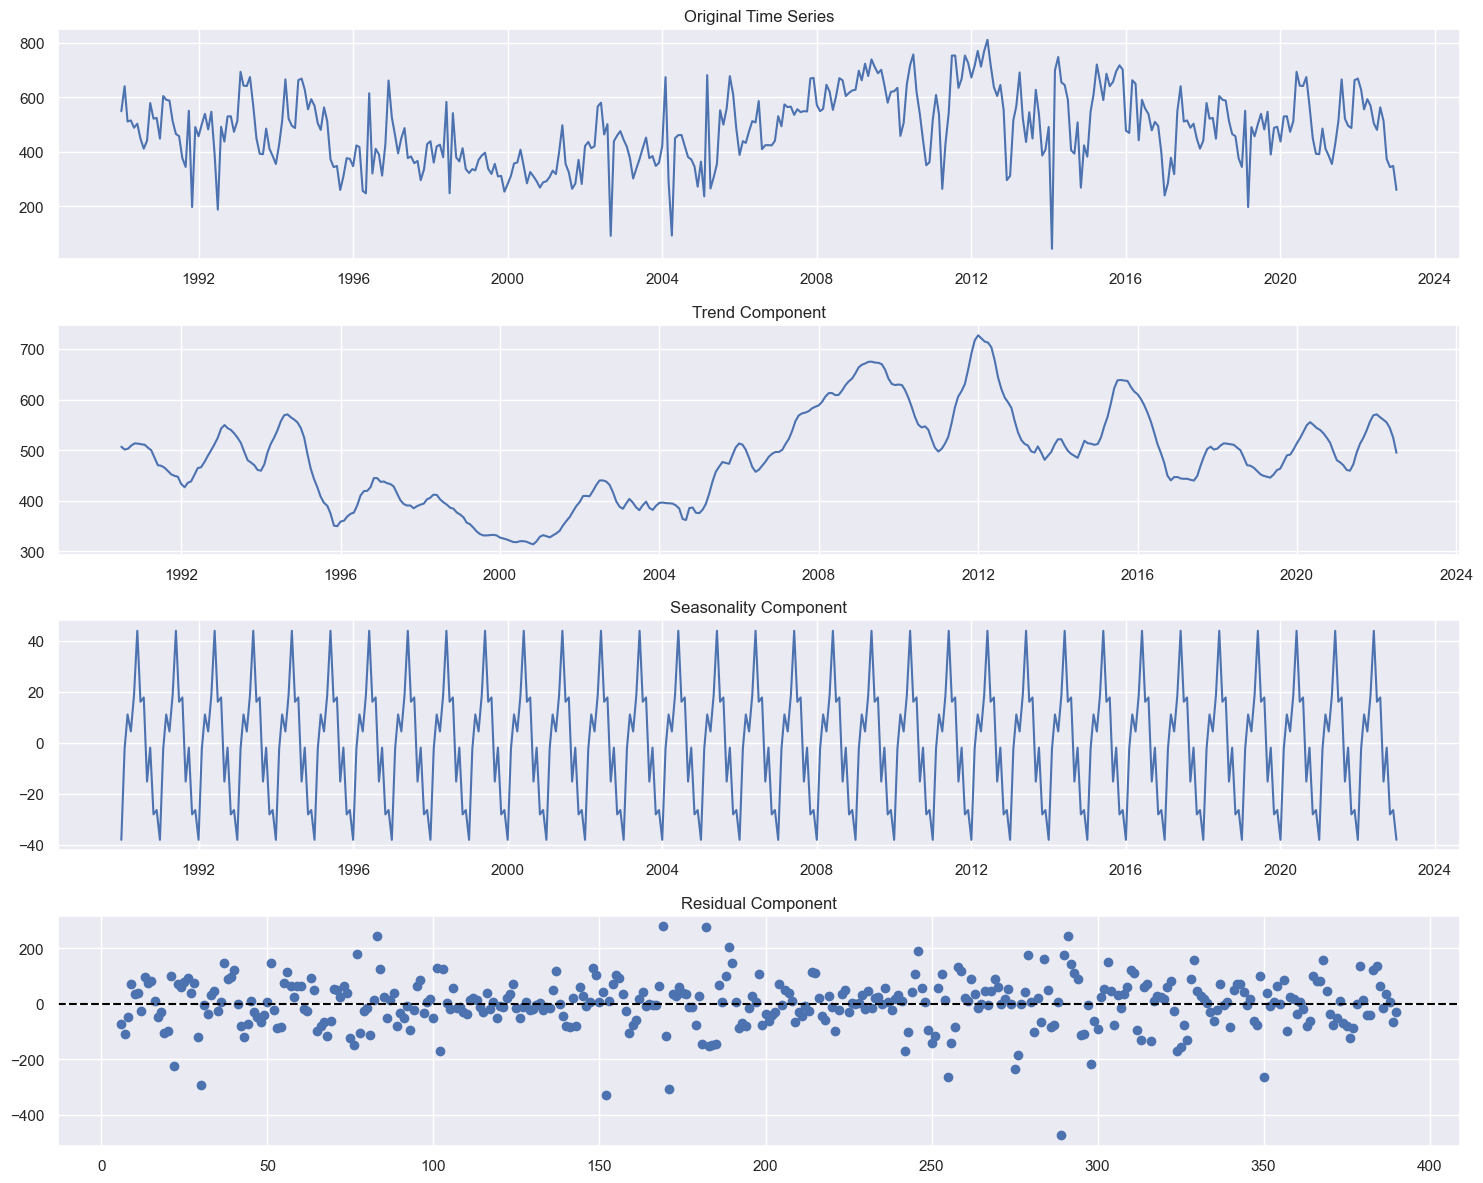

In [400]:
plot_decomposition(df, 'Water Consumption (tons)')


#### **Analysis of all the decompositions**


There are a few points we can extract from this decomposition

- 

---


## *Test for cointegration*

In [249]:
import statsmodels.api as sm

# Assume you have two time series variables, x and y

# Fit a regression model
regression_model = sm.OLS(df['Gas Consumption (tons)'], sm.add_constant(df[('Water Consumption (tons)')])).fit()

# Calculate the residuals
residuals = regression_model.resid

# Perform ADF test on residuals
adf_test = sm.tsa.stattools.adfuller(residuals)

# Extract the p-value from the ADF test result
p_value = adf_test[1]

# Check for cointegration based on the p-value
if p_value < 0.05:
    print("Cointegration exists.")
else:
    print("No cointegration.")

Cointegration exists.


In [314]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assume you have a matrix of multiple time series variables, data

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=0, k_ar_diff=12)

# Extract the eigenvalues and trace statistic
eigenvalues = result.eig
trace_statistic = result.lr1

# Determine the number of cointegrating relationships based on trace statistic
significance_level = 0.05  # Set your desired significance level
num_cointegrating = np.sum(trace_statistic > significance_level)

print("Number of cointegrating relationships:", num_cointegrating)

Number of cointegrating relationships: 3


In [319]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assume you have a matrix of multiple time series variables, data

# Perform Johansen cointegration test
result = coint_johansen(df1, det_order=0, k_ar_diff=12)

# Extract the eigenvalues and trace statistic
eigenvalues = result.eig
trace_statistic = result.lr1

# Determine the number of cointegrating relationships based on trace statistic
significance_level = 0.05  # Set your desired significance level
# num_cointegrating = np.sum(trace_statistic < significance_level)

# print("Number of cointegrating relationships:", num_cointegrating)
significant_p_values = trace_statistic < significance_level


if any(significant_p_values):
    print("There is evidence of cointegration among the variables.")
    for i, p_value in enumerate(p_values):
        if p_value < significance_level:
            print(f"Variable {i+1}: p-value = {p_value:.4f} (significant)")
        else:
            print(f"Variable {i+1}: p-value = {p_value:.4f}")
else:
    print("There is no evidence of cointegration among the variables.")

There is no evidence of cointegration among the variables.


In [251]:
    # import statsmodels.api as sm

    # # Assuming your DataFrame is named df
    # columns = df.columns

    # # Iterate over the columns
    # for i in range(len(columns)):
    #     for j in range(i+1, len(columns)):
    #         x = df[columns[i]]
    #         y = df[columns[j]]

    #         # Fit a regression model
    #         regression_model = sm.OLS(y, sm.add_constant(x)).fit()

    #         # Calculate the residuals
    #         residuals = regression_model.resid

    #         # Perform ADF test on residuals
    #         adf_test = sm.tsa.stattools.adfuller(residuals)

    #         # Extract the p-value from the ADF test result
    #         p_value = adf_test[1]

    #         # Check for cointegration based on the p-value
    #         if p_value < 0.05:
    #             print(f"Cointegration exists between {columns[i]} and {columns[j]}.")
    #         else:
    #             print(f"No cointegration between {columns[i]} and {columns[j]}.")

In [252]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assume you have a matrix of multiple time series variables, data
# Assuming your DataFrame is named df

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=1, k_ar_diff=12)

# Extract the eigenvalues and trace statistic
eigenvalues = result.eig
trace_statistic = result.lr1

# Determine the number of cointegrating relationships based on trace statistic
significance_level = 0.05  # Set your desired significance level
num_cointegrating = np.sum(trace_statistic > significance_level)

print("Number of cointegrating relationships:", num_cointegrating)

# Get the column names
columns = df.columns

# Iterate over the cointegrating relationships
for i in range(num_cointegrating):
    indices = result.ind[i]
    # Get the column names
    coint_cols =  columns[i]
    print(f"Cointegrating {i+1}: {coint_cols}")

Number of cointegrating relationships: 3
Cointegrating 1: Gas Consumption (tons)
Cointegrating 2: Electricity Consumption (MWh)
Cointegrating 3: Water Consumption (tons)


## *Test for Causation*

In [253]:
lag_order = 2  
max_lag = lag_order + 1 
test_results = grangercausalitytests(df[['Gas Consumption (tons)', 'Water Consumption (tons)']], maxlag=max_lag, verbose=False)

# Extract the p-values from the test results
p_values = [test_results[i+1][0]['ssr_chi2test'][1] for i in range(lag_order)]

# Print the p-values 
for i, p_value in enumerate(p_values):
    lag = i + 1
    print(f"Lag {lag}: p-value = {p_value}")
    if p_value < 0.05:
        print("There is evidence of Granger causality from X to Y at lag", lag)
    else:
        print("There is no evidence of Granger causality from X to Y at lag", lag)

Lag 1: p-value = 0.8930453773019464
There is no evidence of Granger causality from X to Y at lag 1
Lag 2: p-value = 0.8535564707990364
There is no evidence of Granger causality from X to Y at lag 2


In [254]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

columns = df.columns

lag_order = 2  
max_lag = lag_order + 1  

# Loop over each pair of columns
for i in range(len(columns)):
    for j in range(len(columns)):
        if i != j:  # Avoid comparing a column with itself
            col_x = columns[i]
            col_y = columns[j]
            
            # Perform the Granger causality test
            test_results = grangercausalitytests(df[[col_x, col_y]], maxlag=max_lag, verbose=False)


            p_value = test_results[lag_order + 1][0]['ssr_chi2test'][1]

            # Print the result
            print(f"Granger causality between {col_x} and {col_y} at lag {lag_order}: p-value = {p_value}")

            if p_value < 0.05:
                print(f"There is evidence of Granger causality from {col_x} to {col_y} at lag {lag_order}")
            else:
                print(f"There is no evidence of Granger causality from {col_x} to {col_y} at lag {lag_order}")
                
            print()

Granger causality between Gas Consumption (tons) and Electricity Consumption (MWh) at lag 2: p-value = 0.301822507018188
There is no evidence of Granger causality from Gas Consumption (tons) to Electricity Consumption (MWh) at lag 2

Granger causality between Gas Consumption (tons) and Water Consumption (tons) at lag 2: p-value = 0.7349059121081363
There is no evidence of Granger causality from Gas Consumption (tons) to Water Consumption (tons) at lag 2

Granger causality between Electricity Consumption (MWh) and Gas Consumption (tons) at lag 2: p-value = 0.4879484717782562
There is no evidence of Granger causality from Electricity Consumption (MWh) to Gas Consumption (tons) at lag 2

Granger causality between Electricity Consumption (MWh) and Water Consumption (tons) at lag 2: p-value = 0.8272737183967803
There is no evidence of Granger causality from Electricity Consumption (MWh) to Water Consumption (tons) at lag 2

Granger causality between Water Consumption (tons) and Gas Consumpt

## *Outlier Detection*

>since we are using a time series detecting outliers can't involve data in the future of the point we are try to evaluate so we have to evaluate on a rolling basis, how that works is visualized below for easier understand

| Window 1 | Window 2 | Window 3 | Window 4 | Window 5 | Window 6 | Window 7 | Window 8 |
|----------|----------|----------|----------|----------|----------|----------|----------|
|     1    |     2    |     3    |          |          |          |          |          |
|          |     2    |     3    |     4    |          |          |          |          |
|          |          |     3    |     4    |     5    |          |          |          |
|          |          |          |     4    |     5    |     6    |          |          |
|          |          |          |          |     5    |     6    |     7    |          |
|          |          |          |          |          |     6    |     7    |     8    |
|          |          |          |          |          |          |     7    |     8    |
|          |          |          |          |          |          |          |     8    |

In [348]:
def detect_rolling_outliers_iqr(time_series, window_size=12, k=1.5):
    outliers = []
    for i in range(len(time_series)):
        
        # Sets a temp window
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        subset = time_series[start_index:end_index]
        
        # evaluate the IQR for that temp window
        q1 = np.percentile(subset, 25)
        q3 = np.percentile(subset, 75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        
        # Evaluate if its a outlier or not
        is_outlier = (time_series[i] < lower_bound) or (time_series[i] > upper_bound)
        outliers.append(is_outlier)
    
    return outliers

In [361]:
def plot_time_series_with_outliers(time_series, outliers, title):
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label='Original Data')

    # Create a dataframe to store the outlier values
    outliers_df = pd.DataFrame({'Outlier Values': time_series[outliers]})

    # Plot the outliers
    plt.scatter(outliers_df.index, outliers_df['Outlier Values'], color='red', label='Outliers')

    plt.xlabel('Index')
    plt.ylabel(title)
    plt.title(f'{title} Rolling IQR Outliers Analysis')
    plt.legend()
    plt.show()

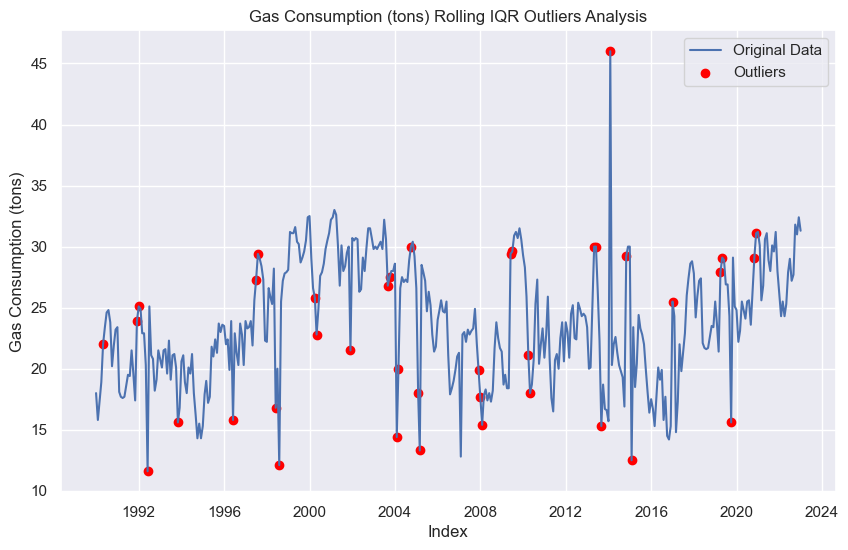

In [362]:

time_series = df['Gas Consumption (tons)']
outliers = detect_rolling_outliers_iqr(time_series)


outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})


plot_time_series_with_outliers(time_series, outliers, 'Gas Consumption (tons)')


---

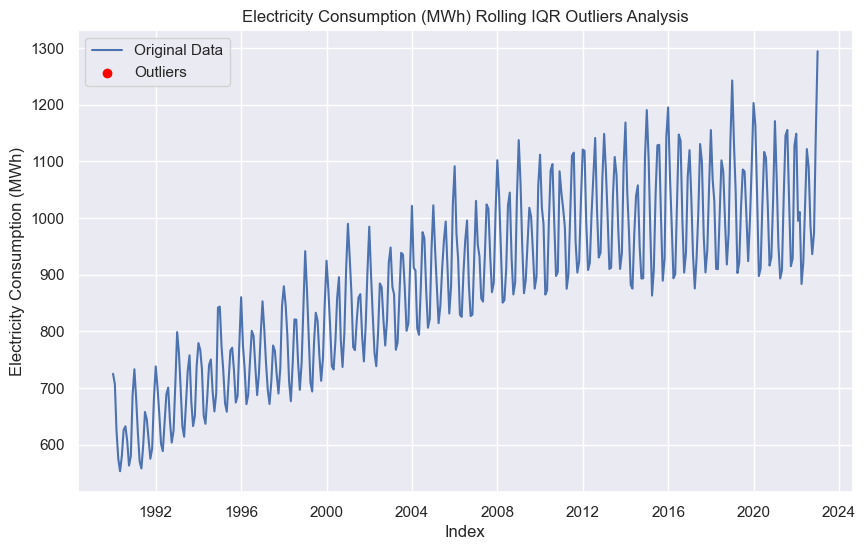

In [381]:
# Example usage
time_series = df['Electricity Consumption (MWh)']
outliers = detect_rolling_outliers_iqr(time_series)

# Print the true outlier values
outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

#outliers_df

plot_time_series_with_outliers(time_series, outliers, 'Electricity Consumption (MWh)')


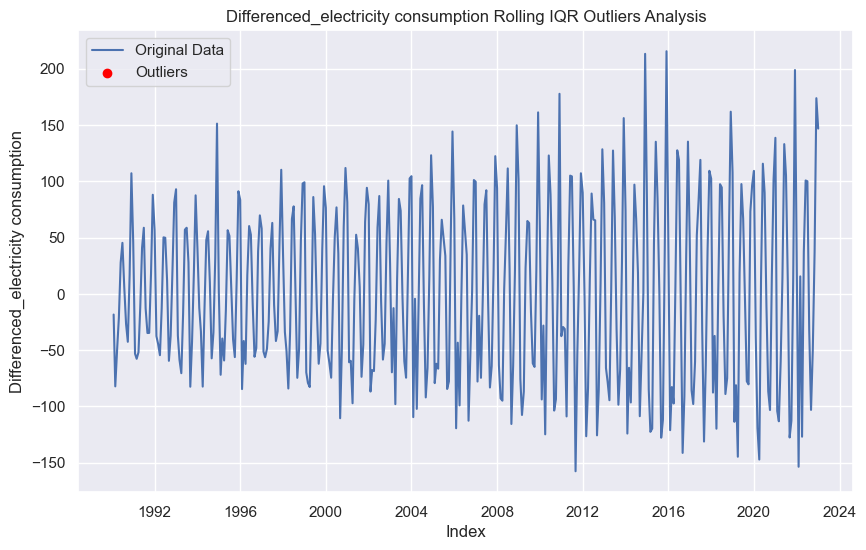

In [366]:
# Example usage
time_series = df1['Differenced_electricity']
outliers = detect_rolling_outliers_iqr(time_series)

# Print the true outlier values
outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

#outliers_df

plot_time_series_with_outliers(time_series, outliers, 'Differenced_electricity consumption')


---

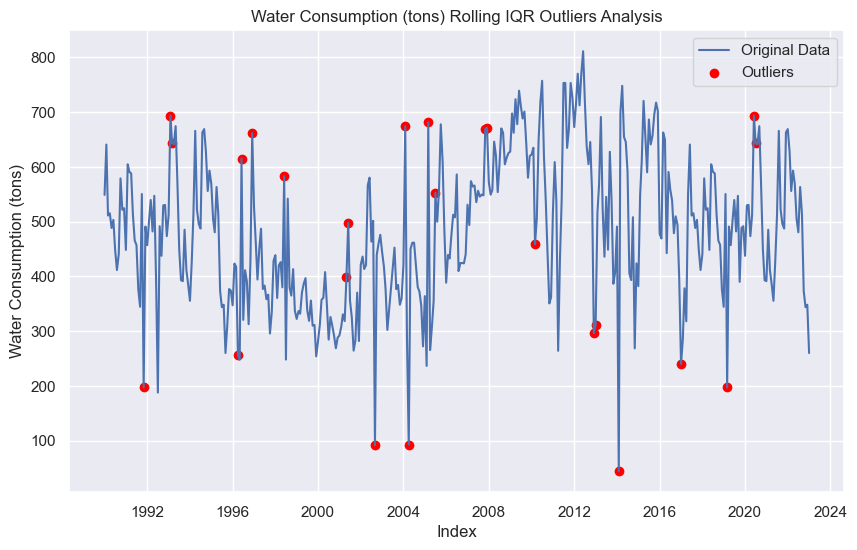

In [368]:
# Example usage
time_series = df['Water Consumption (tons)']
outliers = detect_rolling_outliers_iqr(time_series)

# Print the true outlier values
outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

#outliers_df
plot_time_series_with_outliers(time_series, outliers, 'Water Consumption (tons)')


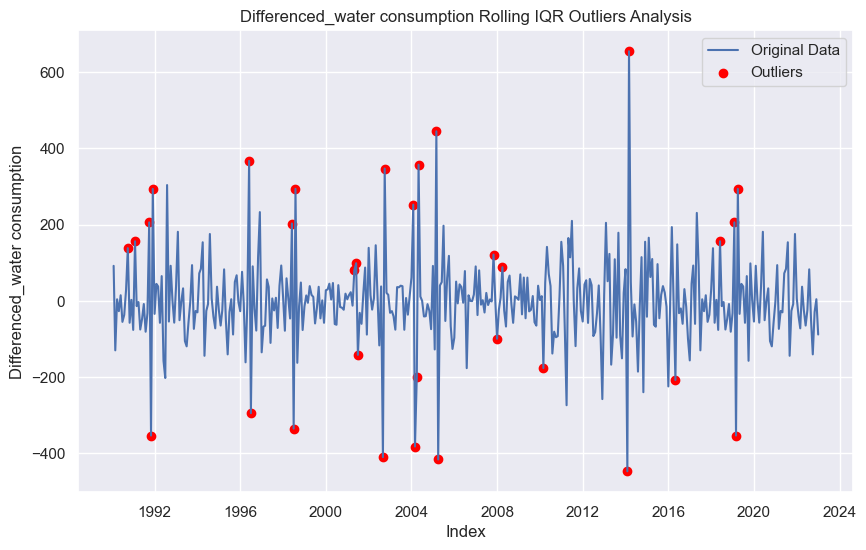

In [367]:
# Example usage
time_series = df1['Differenced_water']
outliers = detect_rolling_outliers_iqr(time_series)

# Print the true outlier values
outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

#outliers_df

plot_time_series_with_outliers(time_series, outliers, 'Differenced_water consumption')


---

## *Autocorrelation Analysis*

In [272]:
def autocorrelation_plot(data, lags):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot ACF
    plot_acf(data, lags=lags, ax=axes[0])
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Autocorrelation Plot')

    # Plot PACF
    plot_pacf(data, lags=lags, ax=axes[1])
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Partial Autocorrelation')
    axes[1].set_title('Partial Autocorrelation Plot')

    plt.tight_layout()
    plt.show()




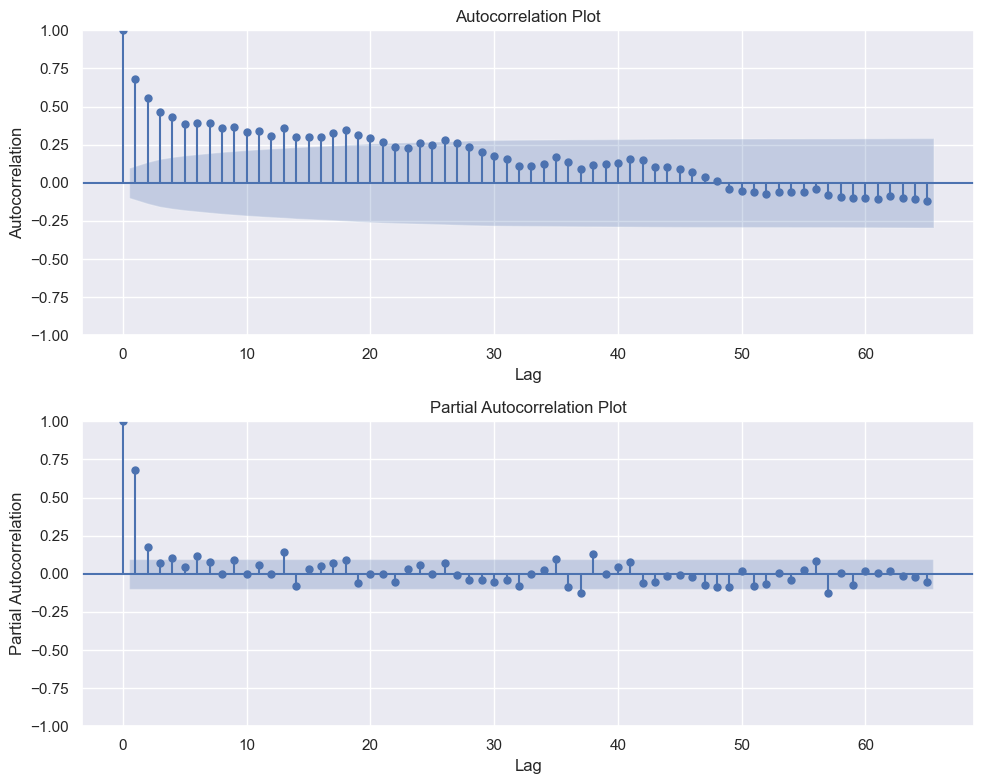

In [273]:
autocorrelation_plot(df['Gas Consumption (tons)'], lags=65)

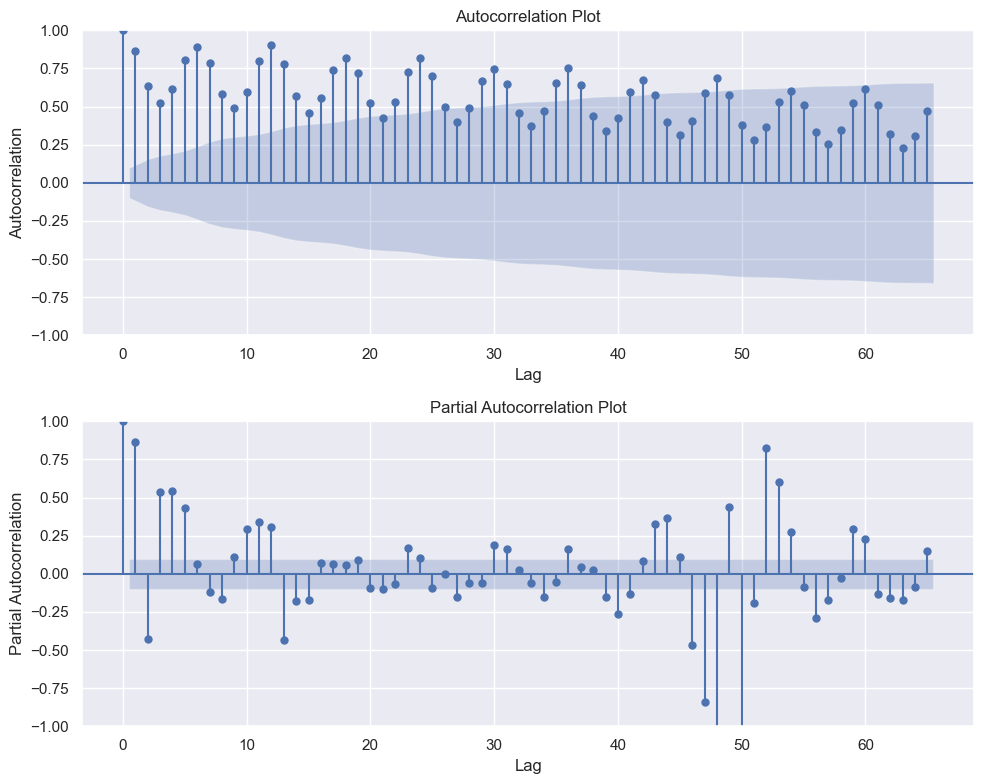

In [369]:
autocorrelation_plot(df['Electricity Consumption (MWh)'], lags=65)

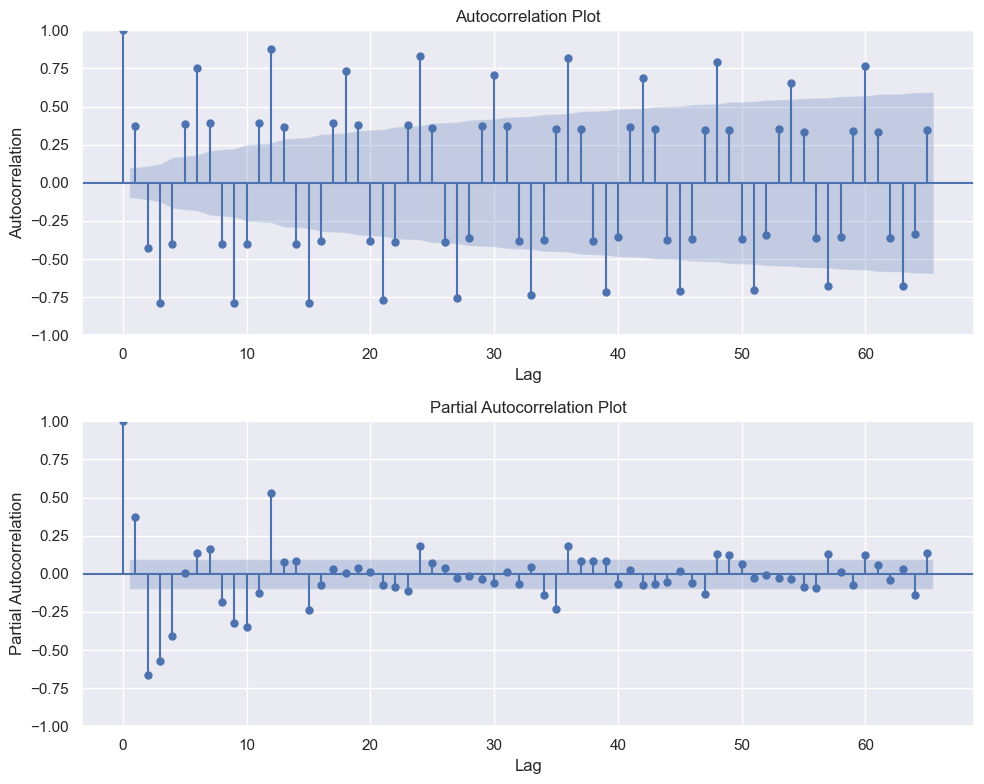

In [390]:
autocorrelation_plot(df1['Differenced_electricity'], lags=65)

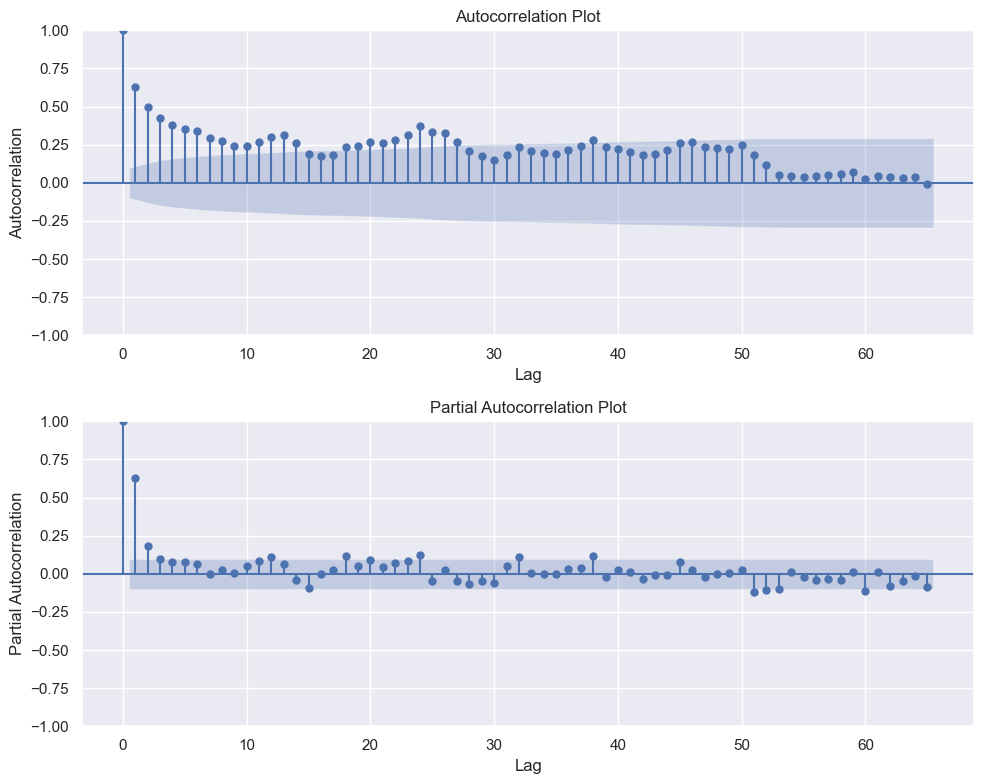

In [274]:
autocorrelation_plot(df['Water Consumption (tons)'], lags=65)

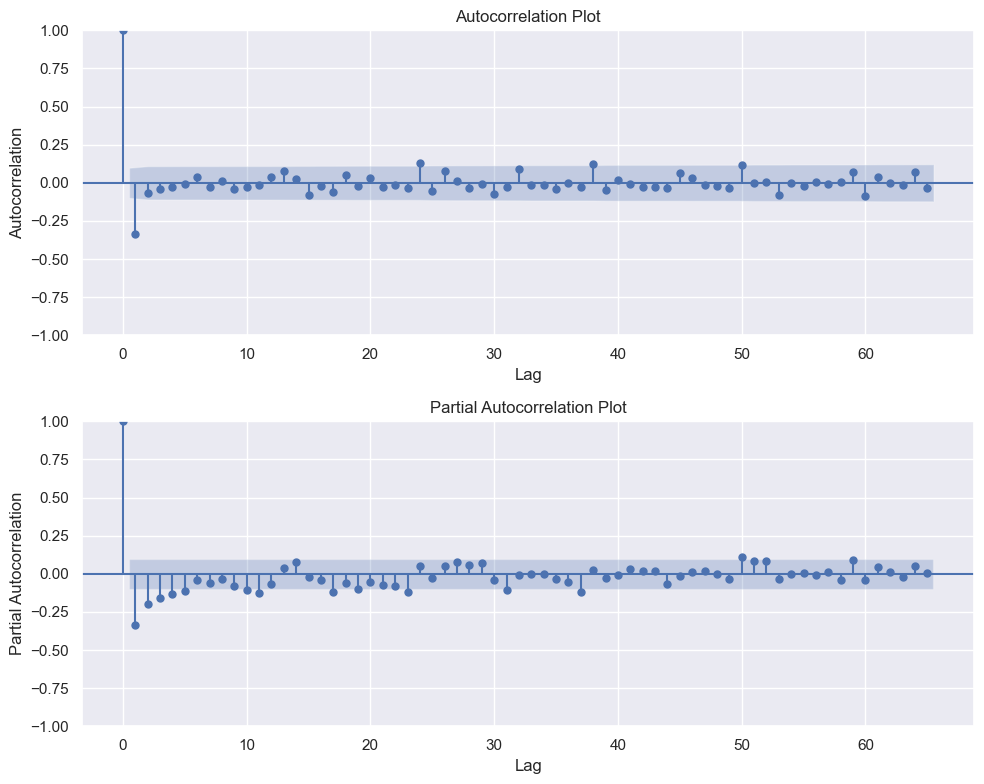

In [288]:
autocorrelation_plot(df1['Differenced_water'], lags=65)

---

# Model Selection

based on the analysis we did above, we can start model selection for our forecasting, we will be using the following models:

- ARIMA
- SARIMA
- Exponential Smoothing
- Holt-Winters Seasonal Smoothing

In [392]:
df

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


In [403]:
# plot_decomposition(final_df, 'Differenced_Electricity')

In [404]:
# plot_decomposition(final_df, 'Differenced_Water')

ARIMA MODELS

Parameters needed for arima [p,d,q]

based on the analysis i did i found the parameters for the ARIMA model to be 


PARAMETER `(Gas Consumption)` = `[1, 0, 1]`

PARAMETER `(Electricity Consumption)` = `[1, 1, 1]`

PARAMETER `(Water Consumption)` = `[1, 1, 1]`

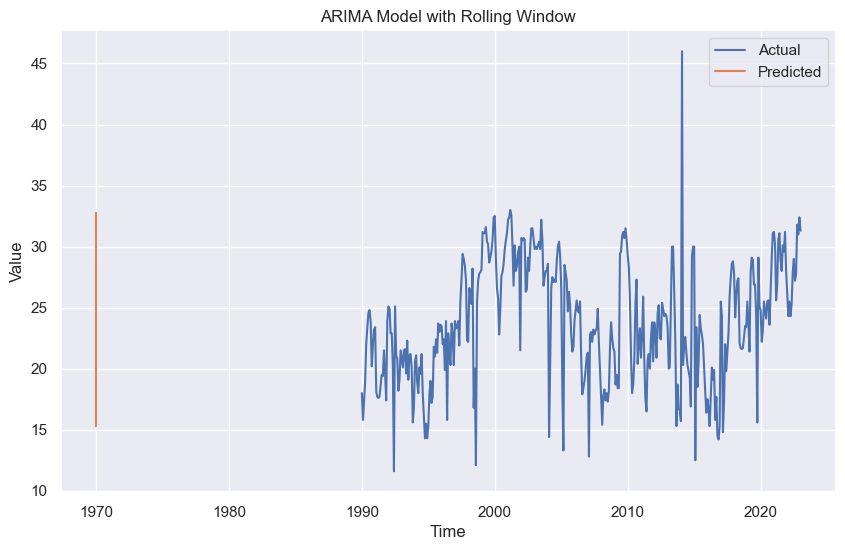

In [417]:
from statsmodels.tsa.arima.model import ARIMA

window_size = 24  
predictions = pd.DataFrame(index=df.index, columns=['predicted_value'])

for i in range(window_size, len(df)):
    train_data = df['Gas Consumption (tons)'].iloc[i-window_size:i]  # Select the current window of data
    test_data = df['Gas Consumption (tons)'].iloc[i]  # Select the next data point to predict
    
    # Fit ARIMA model
    model = ARIMA(train_data, order=(1, 0, 1))  # Adjust the order as needed
    model_fit = model.fit()
    
    # Make one-step ahead prediction
    forecast = model_fit.forecast(steps=1)[0]

    # Store the predicted value in the DataFrame
    predictions.loc[test_data, 'predicted_value'] = forecast

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(df['Gas Consumption (tons)'], label='Actual')
plt.plot(predictions['predicted_value'], label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model with Rolling Window')
plt.show()

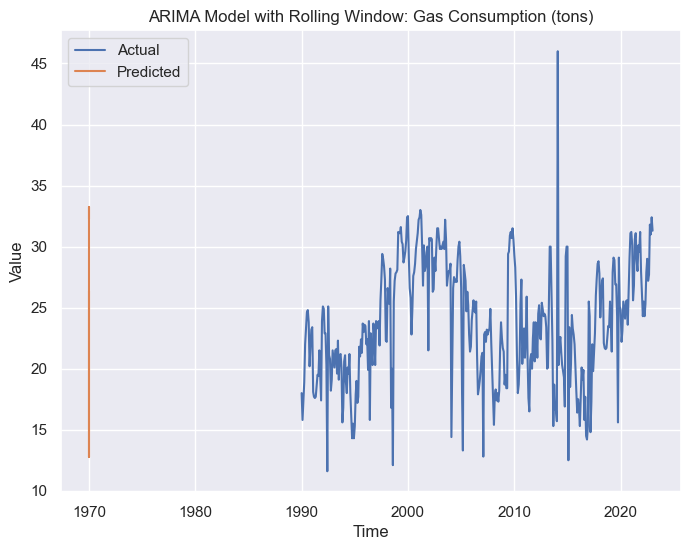

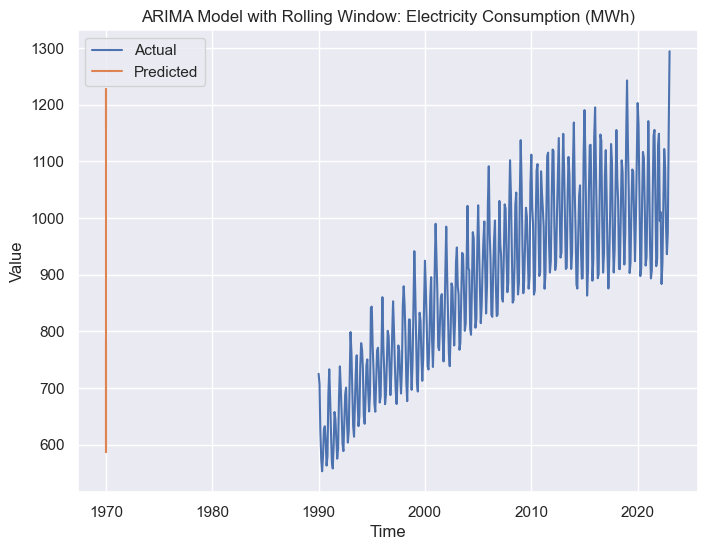

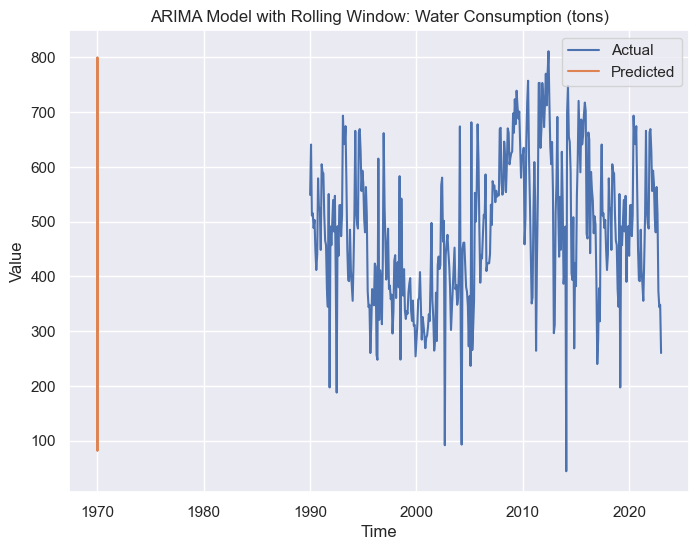

In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming your DataFrame is named 'df' with columns as the features

window_size = 24  # Define the window size

# Create an empty DataFrame to store the predicted values
predictions = pd.DataFrame(index=df.index)

# Loop through each column in the DataFrame
for col in df.columns:
    # Perform ARIMA modeling with rolling window
    for i in range(window_size, len(df)):
        train_data = df[col].iloc[i-window_size:i]  # Select the current window of data
        test_data = df[col].iloc[i]  # Select the next data point to predict

        # Fit ARIMA model
        model = ARIMA(train_data, order=(2, 1, 1))  # Adjust the order as needed
        model_fit = model.fit()

        # Make one-step ahead prediction
        forecast = model_fit.forecast(steps=1)[0]

        # Store the predicted value in the DataFrame
        predictions.loc[test_data, col] = forecast

    # Plot the actual and predicted values for the current feature
    plt.figure(figsize=(8, 6))
    plt.plot(df[col], label='Actual')
    plt.plot(predictions[col], label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('ARIMA Model with Rolling Window: ' + col)
    plt.show()

In [441]:
def rolling_arima_forecast(df, target_feature, p, d, q, window_size):
    # Initialize an empty DataFrame to store the forecasts
    forecast_df = pd.DataFrame(columns=['Date', f'{target_feature} Forecast'])

    # Perform rolling forecast
    for i in range(len(df) - window_size):
        # Split the data into train and test sets
        train = df[target_feature].iloc[i:i+window_size]
        test = df[target_feature].iloc[i+window_size:i+window_size+1]

        # Fit the ARIMA model
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()

        # Make the forecast
        forecast = model_fit.forecast(steps=1).iloc[0]
        # Append the forecast to the DataFrame
        forecast_df = forecast_df.append({'Date': test.index[0], f'{target_feature} Forecast': forecast}, ignore_index=True)

    return forecast_df

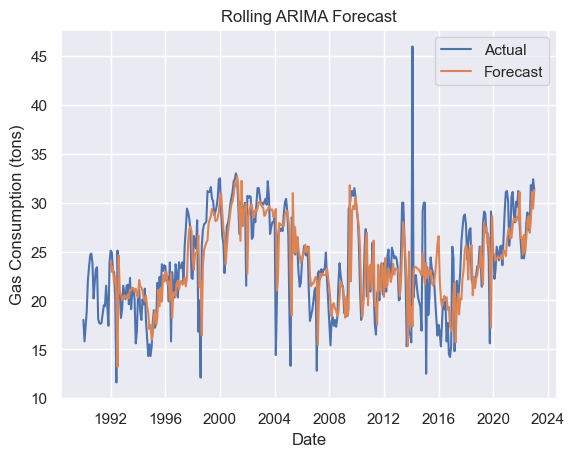

In [450]:
target_feature = 'Gas Consumption (tons)'

forecast_df = rolling_arima_forecast(df, target_feature, 1, 0, 1, 24)
forecast_df = forecast_df.set_index('Date')


plt.plot(df.index, df[target_feature], label='Actual')
plt.plot(forecast_df.index, forecast_df[f'{target_feature} Forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel(target_feature)
plt.title('Rolling ARIMA Forecast')
plt.legend()
plt.show()

# Print the forecasted values
# print(forecast_df)

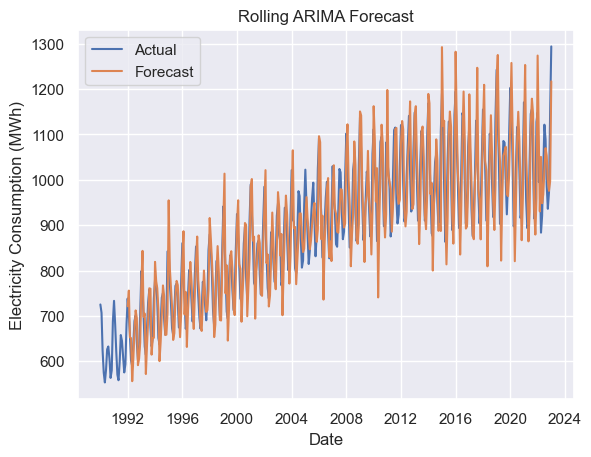

In [444]:
target_feature = 'Electricity Consumption (MWh)'

forecast_df = rolling_arima_forecast(df, target_feature, 1, 1, 1, 24)
forecast_df = forecast_df.set_index('Date')


plt.plot(df.index, df[target_feature], label='Actual')
plt.plot(forecast_df.index, forecast_df[f'{target_feature} Forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel(target_feature)
plt.title('Rolling ARIMA Forecast')
plt.legend()
plt.show()


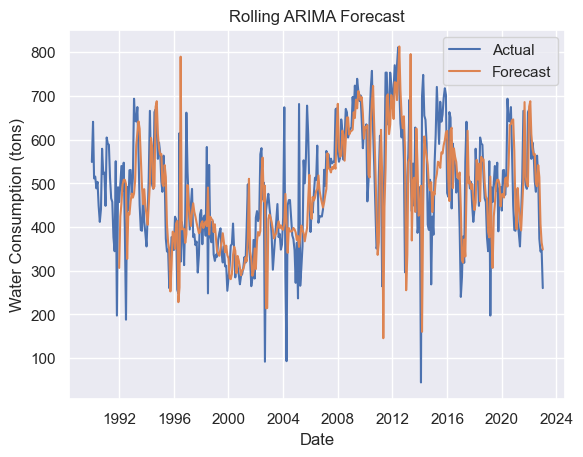

In [445]:
target_feature = 'Water Consumption (tons)'

forecast_df = rolling_arima_forecast(df, target_feature, 1, 1, 1, 24)
forecast_df = forecast_df.set_index('Date')


plt.plot(df.index, df[target_feature], label='Actual')
plt.plot(forecast_df.index, forecast_df[f'{target_feature} Forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel(target_feature)
plt.title('Rolling ARIMA Forecast')
plt.legend()
plt.show()

In [449]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA

# # Assuming you have a DataFrame named 'df' with columns 'feature1', 'feature2', etc.
# # Set the desired order for ARIMA (p, d, q)
# p = 1  # AR order
# d = 0  # I order (no differencing)
# q = 1  # MA order

# # Specify the column name for the feature you want to forecast
# target_feature = 'Gas Consumption (tons)'

# # Set the window size for rolling forecast
# window_size = 24

# # Initialize an empty DataFrame to store the forecasts
# forecast_df = pd.DataFrame(columns=['Date', 'Gas Consumption Forecast'])

# # Perform rolling forecast
# for i in range(len(df) - window_size):
#     # Split the data into train and test sets
#     train = df[target_feature].iloc[i:i+window_size]
#     test = df[target_feature].iloc[i+window_size:i+window_size+1]

#     # Fit the ARIMA model
#     model = ARIMA(train, order=(p, d, q))
#     model_fit = model.fit()

#     # Make the forecast
#     forecast = model_fit.forecast(steps=1).iloc[0]
#     # Append the forecast to the DataFrame
#     forecast_df = forecast_df.append({'Date': test.index[0], 'Gas Consumption Forecast': forecast}, ignore_index=True)

# # Print the forecast DataFrame
# # 
# forecast_df = forecast_df.set_index('Date')

# forecast_df


In [448]:
# import matplotlib.pyplot as plt

# # Plot the original time series
# plt.plot(df.index, df['Gas Consumption (tons)'], label='Original Time Series')

# # Plot the forecasted values
# plt.plot(forecast_df.index, forecast_df['Gas Consumption Forecast'], label='Forecasted Time Series')

# # Set plot labels and legend
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Original Time Series vs Forecasted Time Series')
# plt.legend()

# # Show the plot
# plt.show()

In [447]:
# # Assuming you have a DataFrame named 'df' with columns 'feature1', 'feature2', etc.
# # Set the desired order for ARIMA (p, d, q)
# p = 1  # AR order
# d = 1  # I order (no differencing)
# q = 1  # MA order

# # Specify the column name for the feature you want to forecast
# target_feature = 'Electricity Consumption (MWh)'

# # Set the window size for rolling forecast
# window_size = 24

# # Initialize an empty DataFrame to store the forecasts
# # forecast_df = pd.DataFrame(columns=['Date', 'Gas Consumption Forecast'])

# # Perform rolling forecast
# for i in range(len(df) - window_size):
#     # Split the data into train and test sets
#     train = df[target_feature].iloc[i:i+window_size]
#     test = df[target_feature].iloc[i+window_size:i+window_size+1]

#     # Fit the ARIMA model
#     model = ARIMA(train, order=(p, d, q))
#     model_fit = model.fit()

#     # Make the forecast
#     forecast = model_fit.forecast(steps=1).iloc[0]
#     # Append the forecast to the DataFrame

#     forecast_df = forecast_df.append({ 'Electricity Consumption Forecast': forecast}, ignore_index=True)

# # Print the forecast DataFrame
# # 
# # forecast_df = forecast_df.set_index('Date')

# forecast_df

# References 

- `Stationarity`  
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#When_to_Choose_ADF_or_KPSS_Test?

- `Unit Root`  
https://en.wikipedia.org/wiki/Unit_root

- `Autocorrelation`  
https://www.youtube.com/watch?v=gDwx3RPUfPw

---

# Carbonara Recipe

## Ingredients
- 8 ounces spaghetti
- 4 slices bacon, chopped
- 2 cloves garlic, minced
- 2 large eggs
- 1/2 cup grated Parmesan cheese
- 1/4 cup heavy cream
- Salt and pepper, to taste
- Chopped fresh parsley, for garnish

## Instructions
1. Cook the spaghetti according to package instructions until al dente. Drain and set aside.
2. In a large skillet, cook the chopped bacon over medium heat until crispy. Remove the bacon from the skillet and set aside.
3. In the same skillet, add the minced garlic and cook for about 1 minute, until fragrant.
4. In a medium bowl, whisk together the eggs, grated Parmesan cheese, and heavy cream. Season with salt and pepper.
5. Pour the egg mixture into the skillet with the garlic and stir quickly to combine. Cook for about 1 minute, stirring constantly, until the sauce thickens slightly.
6. Add the cooked spaghetti to the skillet and toss until the pasta is coated evenly with the sauce.
7. Remove the skillet from heat and add the crispy bacon. Toss again to combine.
8. Garnish with chopped fresh parsley.
9. Serve the Carbonara immediately while it's still warm.

Enjoy your delicious Carbonara!